In [1]:
import findspark
findspark.init()

In [2]:
import numpy as np
import pandas as pd

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

In [4]:
spark = SparkSession.builder \
    .appName("MovieRecomSys") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

In [5]:
movies = spark.read.csv(r"movies.csv", header=True, inferSchema=True)
ratings = spark.read.csv(r"ratings.csv", header=True, inferSchema=True)

In [6]:
movies.show(5)
ratings.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
+------+-------+------+----------+
only showing top 5 rows



In [7]:
movies.printSchema()
ratings.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [8]:
movies.select([count(when(col(c).isNull(), c)).alias(c) for c in movies.columns]).show()
ratings.select([count(when(col(c).isNull(), c)).alias(c) for c in ratings.columns]).show()

+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+



# 1. Data Visualization

In [8]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg

In [9]:
# 1. Calculate the average rating and the number of ratings for each movie
movie_stats = ratings.groupBy("movieId").agg(
    avg("rating").alias("avg_rating"),
    count("rating").alias("num_ratings")
)

In [10]:
# 2. Filter movies with a minimum number of ratings (e.g., at least 50 ratings)
filtered_movies = movie_stats.filter(movie_stats["num_ratings"] >= 50)

In [11]:
# 3. Join with the movie names based on the movieId column
combined_data = filtered_movies.join(movies, on="movieId")

In [12]:
# 4. Convert the PySpark DataFrame to a Pandas DataFrame for plotting
combined_data_pd = combined_data.toPandas()

In [13]:
# 5. Sort by average rating
top_n = 10
combined_data_pd = combined_data_pd.sort_values(by="avg_rating", ascending=False).head(top_n)

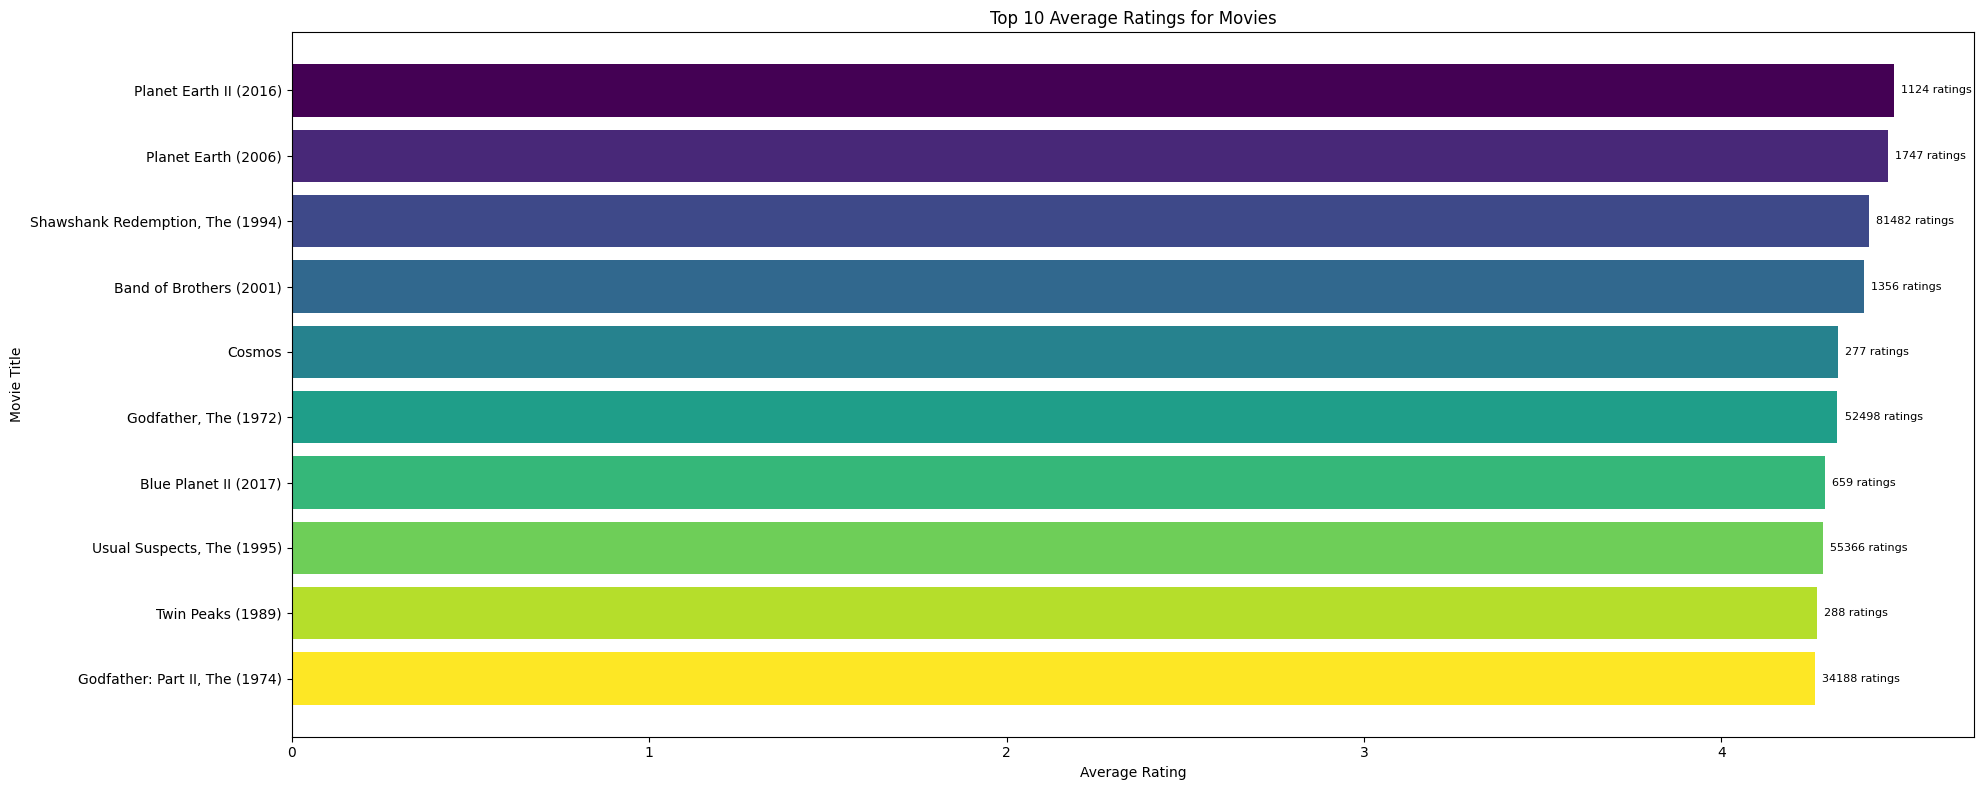

In [15]:
# 6. Create a bar plot showing average rating with the number of ratings
plt.figure(figsize=(20, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(combined_data_pd)))
bars = plt.barh(combined_data_pd["title"], combined_data_pd["avg_rating"], color=colors)

# 7. Add text annotations to show the number of ratings next to each bar
for bar, num_ratings in zip(bars, combined_data_pd["num_ratings"]):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{num_ratings} ratings', va='center', ha='left', fontsize=8)

plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.title("Top 10 Average Ratings for Movies")

# Rotate y-axis labels if needed
plt.yticks(rotation=0)  # Change to 90 if you want vertical labels
# Use subplots_adjust to manually set margins
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)

plt.gca().invert_yaxis()  # Invert y-axis so the highest-rated movie is on top
plt.tight_layout()
plt.show()

# 2. Model Training

In [9]:
train_data, test_data = ratings.randomSplit([0.8, 0.2], seed=123)

In [10]:
print("Number of rows in train_data:", train_data.count())
print("Number of rows in test_data:", test_data.count())

Number of rows in train_data: 19997741
Number of rows in test_data: 5002354


In [11]:
print("Initial partition count:", train_data.rdd.getNumPartitions())

Initial partition count: 20


In [12]:
train_data = train_data.repartition(200)

In [13]:
print("New partition count:", train_data.rdd.getNumPartitions())

New partition count: 200


In [14]:
from pyspark.ml.recommendation import ALS 

In [15]:
als = ALS(maxIter=5, regParam=0.1, rank=5, userCol="userId", itemCol="movieId", ratingCol="rating")

maxIter: The maximum number of iterations for the ALS optimization process.\
regParam: The regularization parameter that helps control overfitting.

In [16]:
model = als.fit(train_data)

In [17]:
predictions = model.transform(test_data)
predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     1|    307|   5.0|1147868828| 3.8094332|
|     1|   1175|   3.5|1147868826| 3.9190965|
|     1|   2011|   2.5|1147868079| 3.2456813|
|     1|   2012|   2.5|1147868068| 2.9614003|
|     1|   2632|   5.0|1147878248|   3.41504|
|     1|   3949|   5.0|1147868678| 4.0552855|
|     1|   4973|   4.5|1147869080|  4.319105|
|     1|   5147|   4.0|1147877654|  3.894529|
|     1|   5767|   5.0|1147878729| 4.3712645|
|     1|   5878|   4.0|1147868807| 4.0041246|
|     1|   5912|   3.0|1147878698| 3.8761215|
|     1|   6370|   4.5|1147869191|  3.931709|
|     1|   6539|   3.5|1147868461| 3.4849713|
|     1|   7327|   3.5|1147868855| 3.9328592|
|     1|   8014|   3.5|1147869155|  4.048539|
|     1|   8729|   3.5|1147878452|  3.028108|
|     2|    261|   0.5|1141417855| 3.2092805|
|     2|    333|   5.0|1141415931| 3.1662085|
|     2|    457|   5.0|1141416618|

# 3. Evaluation

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, count, when

In [19]:
predictions_no_missing = predictions.na.drop(subset=["prediction"])

In [20]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [21]:
rmse = evaluator.evaluate(predictions_no_missing)

In [22]:
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 0.8208943515624083


In [23]:
single_user = test_data.filter(test_data['userId']==1).select(['movieId','userId'])

In [24]:
single_user.show()

+-------+------+
|movieId|userId|
+-------+------+
|    307|     1|
|   1175|     1|
|   2011|     1|
|   2012|     1|
|   2632|     1|
|   3949|     1|
|   4973|     1|
|   5147|     1|
|   5767|     1|
|   5878|     1|
|   5912|     1|
|   6370|     1|
|   6539|     1|
|   7327|     1|
|   8014|     1|
|   8729|     1|
+-------+------+



In [25]:
reccomendations = model.transform(single_user)

In [26]:
reccomendations.orderBy('prediction',ascending=False).show()

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|   5767|     1| 4.3712645|
|   4973|     1|  4.319105|
|   3949|     1| 4.0552855|
|   8014|     1|  4.048539|
|   5878|     1| 4.0041246|
|   7327|     1| 3.9328592|
|   6370|     1|  3.931709|
|   1175|     1| 3.9190965|
|   5147|     1|  3.894529|
|   5912|     1| 3.8761215|
|    307|     1| 3.8094332|
|   6539|     1| 3.4849713|
|   2632|     1|   3.41504|
|   2011|     1| 3.2456813|
|   8729|     1|  3.028108|
|   2012|     1| 2.9614003|
+-------+------+----------+

